<font size=5> **MTH9831 Homework10 Numerical Projects** </font>

<font size=3> **Team members:** </font>
- Chu, Gujia
- Twahir, Omar
- Wu, Chengxun
- Zhu, Bin

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

In [2]:
def generate_bm(T, dt):
    m = int(T / dt) + 1
    randomness = np.random.normal(0, np.sqrt(dt), m)
    randomness[0] = 0
    return randomness.cumsum()

In [3]:
from scipy.stats import norm
from scipy.optimize import fsolve


def BS(T, K, S, t, r, sigma):
    tau = T - t
    d1 = (np.log(S / K) +
          (r + sigma * sigma / 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    c = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    p = K * np.exp(-r * tau) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return c, p


def BS_call_price(T, K, S, t, r, sigma):
    tau = T - t
    d1 = (np.log(S / K) +
          (r + sigma * sigma / 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)


def BS_call_implied_vol(T, K, S, t, r, market_price):
    helper = lambda x: BS_call_price(T, K, S, t, r, x) - market_price
    x_low, x_high = 0.0, 1.0
    while abs(x_high - x_low) >= 1e-4:
        x_approx = (x_high + x_low) * 0.5
        if helper(x_approx) > 0:
            x_high = x_approx
        else:
            x_low = x_approx
    return (x_high + x_low) * 0.5

# The Heston Model

The Heston model is given by
$$
\begin{cases} \mathrm{d}S_t &= r_t S_t \mathrm{d}t + \sqrt{V_t}S_t\mathrm{d}\tilde{B}_t^{(1)}\\
    \mathrm{d}V_t &= (a- b V_t) \mathrm{d}t + \eta \sqrt{V_t}\mathrm{d}\tilde{B}_t^{(2)}
\end{cases}
$$
In this question, we take $$\eta=0.1,a=0.5,b=1,S_0=100,V_0=0.5,r=0$$
with the assumption that two Brownian motions are independent.

In [4]:
def Heston(r, a, b, eta, S0, V0, T, dt, verbose=False):
    B1 = generate_bm(T, dt)
    B2 = generate_bm(T, dt)
    N = int(T / dt) + 1
    S = np.array([float(S0) for _ in range(N)])
    V = np.array([float(V0) for _ in range(N)])
    for i in range(N - 1):
        db1 = B1[i + 1] - B1[i]
        db2 = B2[i + 1] - B2[i]
        # hitting 0? set to 0.
        if V[i] <= 0:
            return -1.0
        else:
            V[i + 1] = V[i] + (a - b * V[i]) * dt + eta * np.sqrt(V[i]) * db2
        S[i + 1] = S[i] + r * S[i] * dt + np.sqrt(V[i]) * S[i] * db1
    if not verbose:
        return S
    return S, V

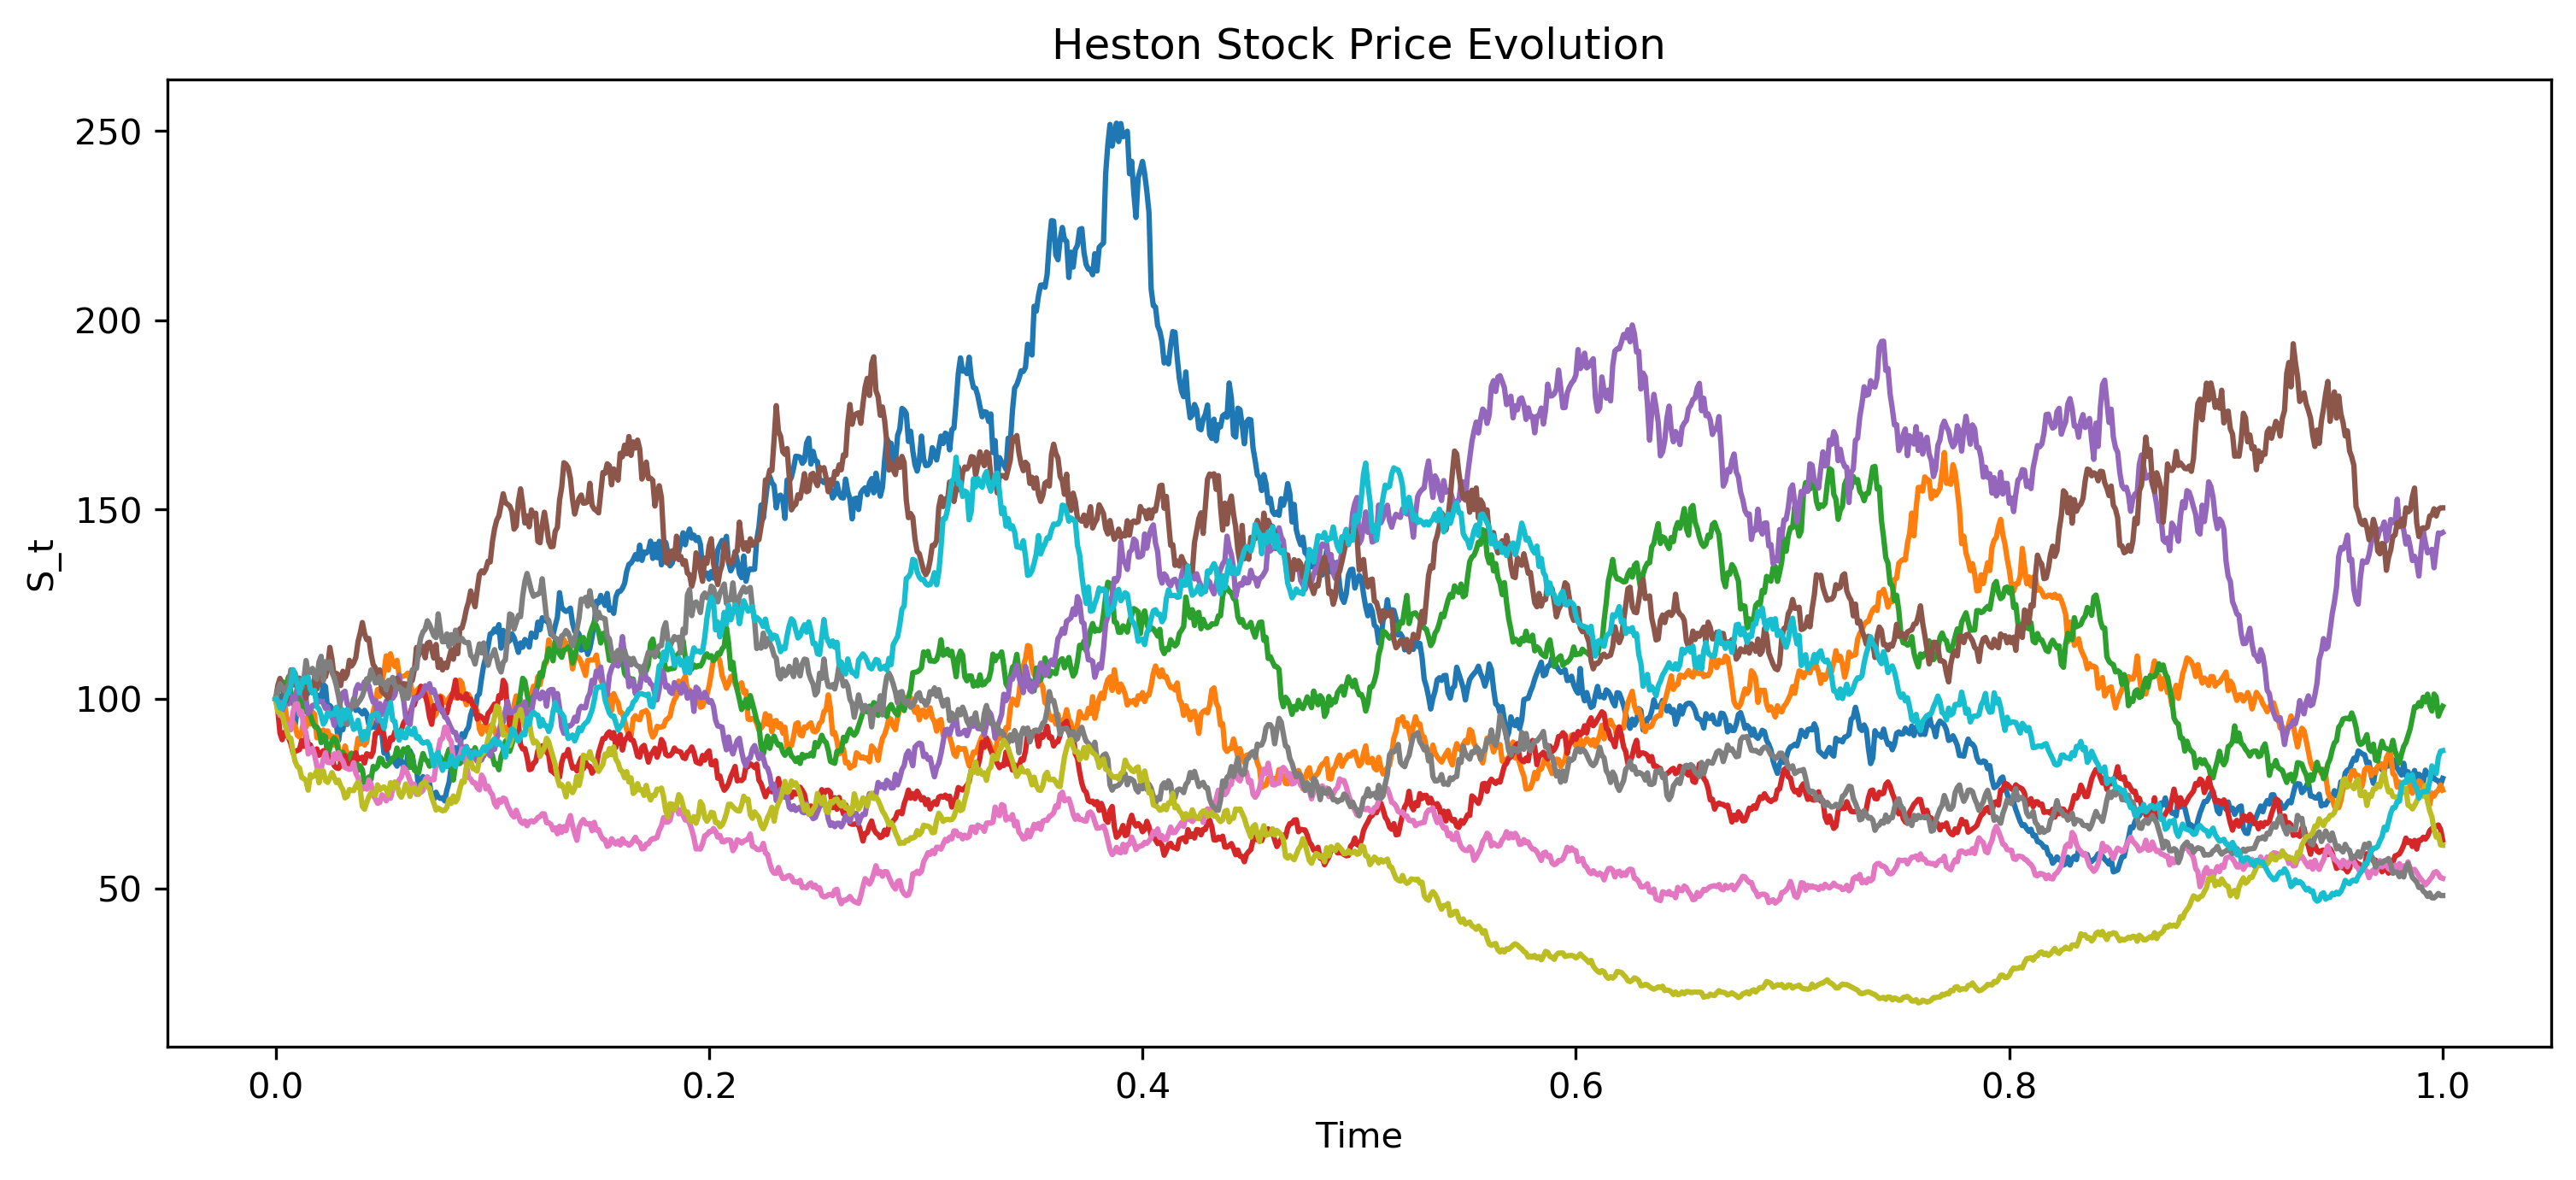

In [5]:
r = 0.0
a = 0.5
b = 1.0
eta = 0.1
S0 = 100.0
V0 = 0.5
T = 1.0
dt = 0.001
time_points = np.arange(0, T + dt, dt)

plt.figure(figsize=(12, 5), dpi=300)
for _ in range(10):
    plt.plot(time_points, Heston(r, a, b, eta, S0, V0, T, dt))
plt.title("Heston Stock Price Evolution")
plt.xlabel("Time")
plt.ylabel("S_t")
plt.show()

# BlackScholes v.s. Heston

Price of options: $$C_0 = \tilde{\mathbb{E}}[C_T]$$
a specific version when we take $t=0$ in the generic version of risk-neutral pricing.

For BS, notice that European call is not path dependent, we can directly call the final result instead of during Euler discretization.

**Parameters:** $\eta=0.5,a=0.1,b=1,S_0=500,V_0=\sigma=0.1, r=0$
We assume that $T=3$, to make the results more obvious.

**Note:** to make the results more accurate, we use 10000 Heston paths to sample on.

Number of non-negative paths: 4492


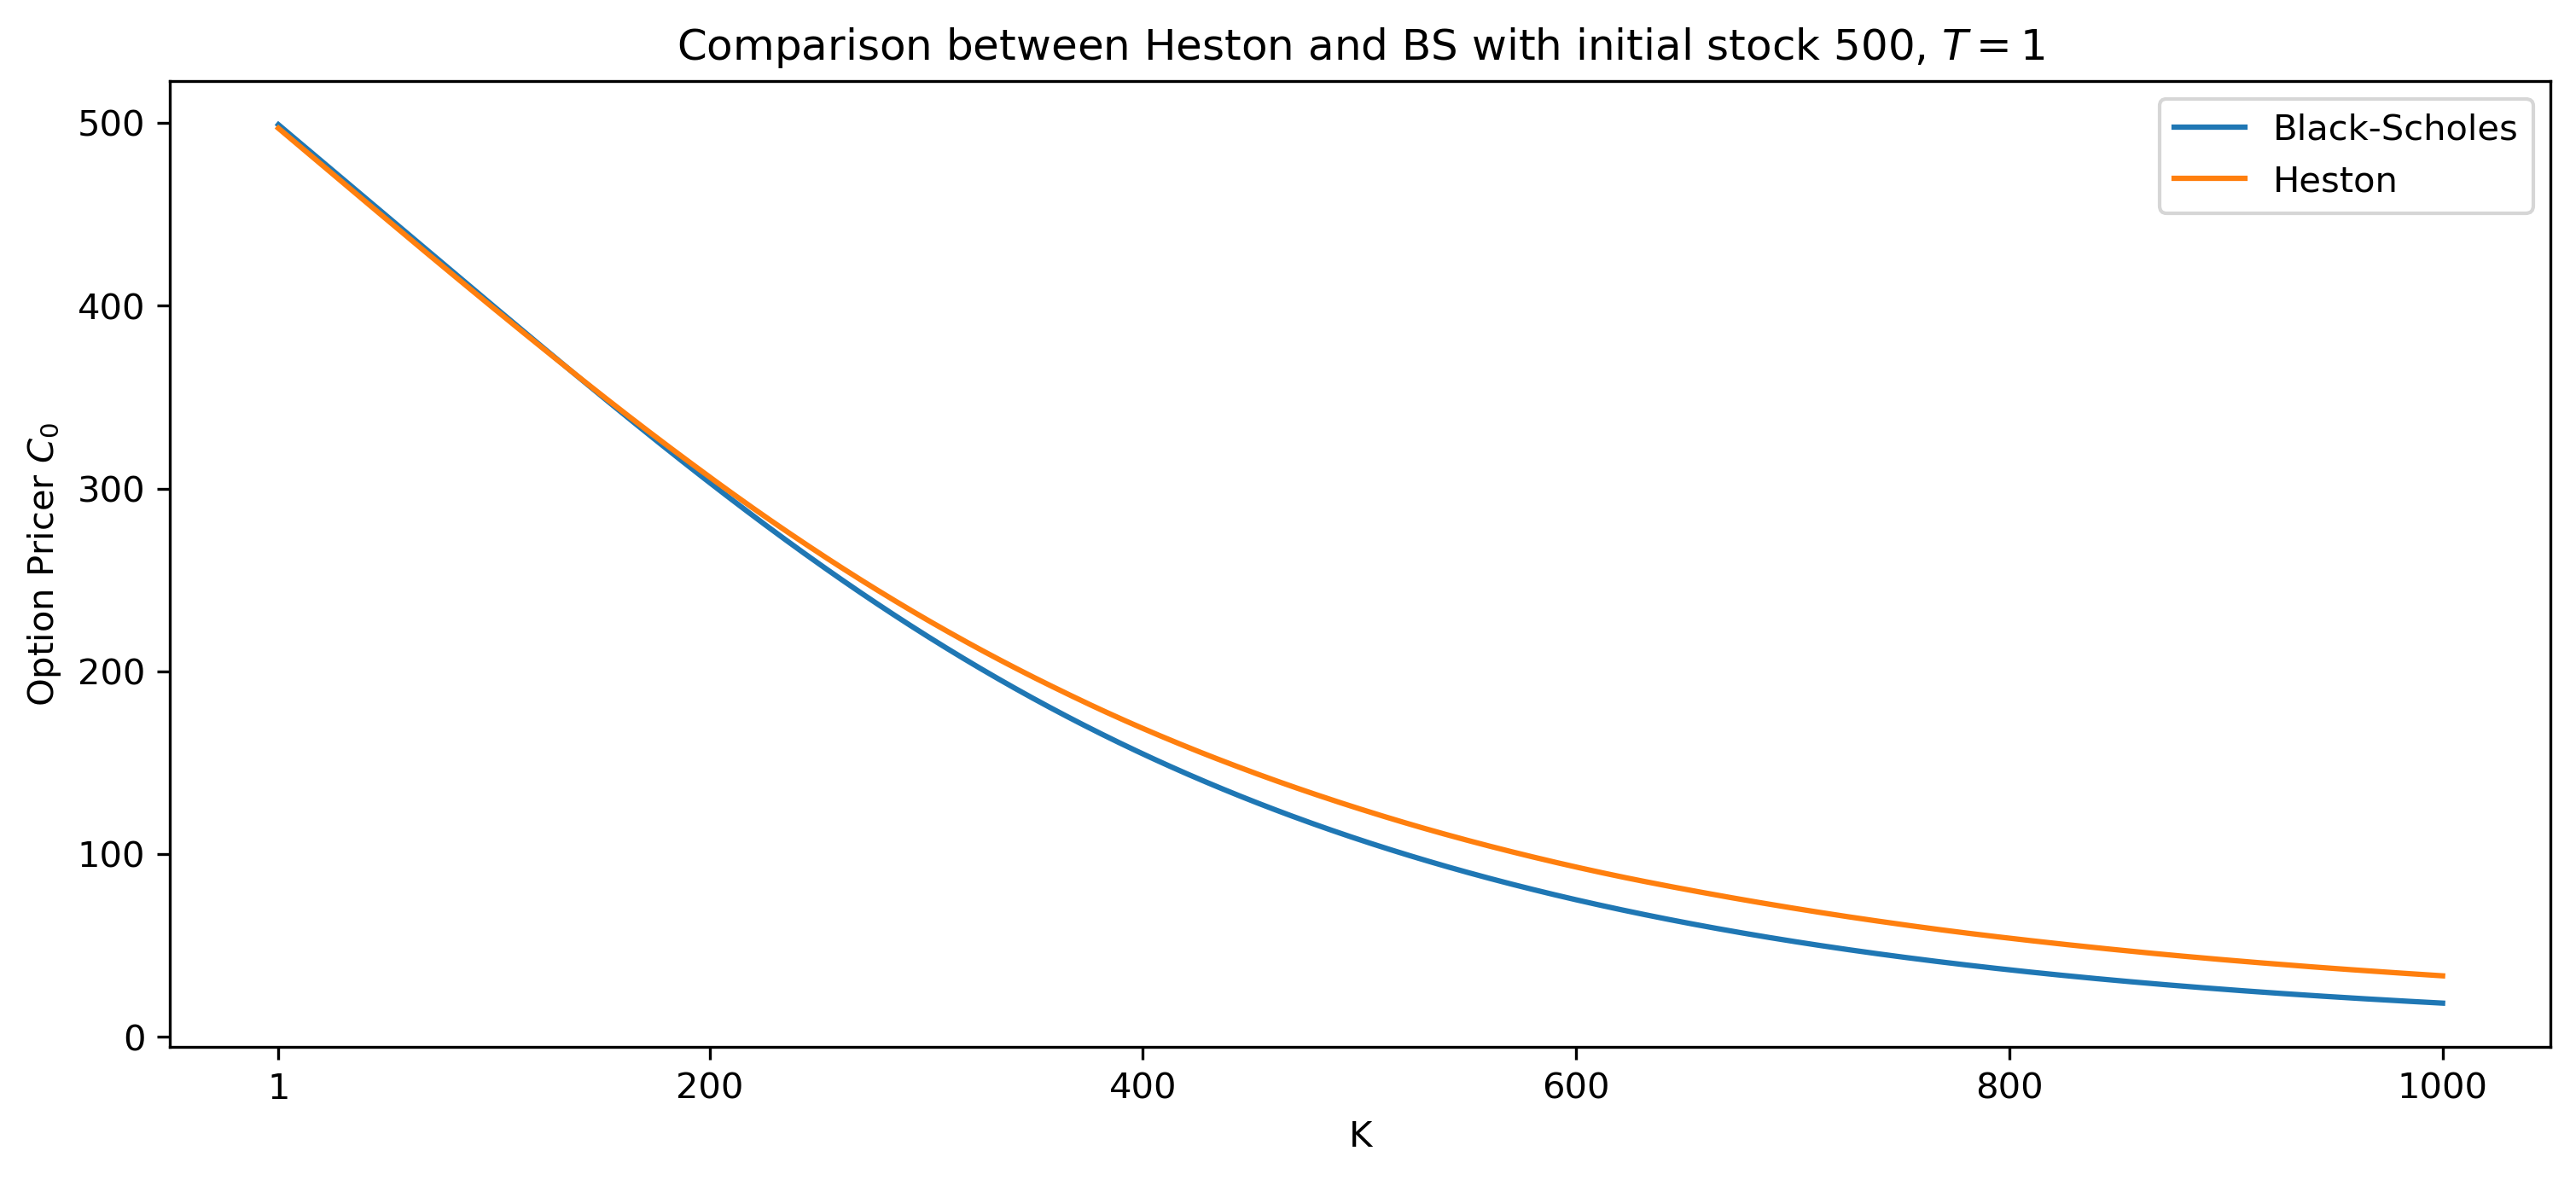

In [6]:
T = 3
r = 0.0
a = 0.1
b = 1.0
eta = 0.5
S0 = 500.0
V0 = 0.1
sigma = np.sqrt(0.1)
dt = 0.01

strikes = np.arange(1, 1001, 1)
bs_res = [0.0 for _ in range(1000)]
x = np.random.normal(size=10000)
for i, k in enumerate(strikes):
    # calculate S_T first, then use element max
    bs_res[i]=BS(T,k,S0,0.0,r,sigma)[0]

# discard the paths hitting 0
heston_res = [0.0 for _ in range(1000)]
hestons = []
for _ in range(10000):
    res = Heston(r, a, b, eta, S0, V0, T, dt)
    if type(res) == float:
        continue
    hestons.append(res[-1])
print("Number of non-negative paths: {}".format(len(hestons)))
hestons = np.array(hestons)

for i, k in enumerate(strikes):
    heston_res[i] = np.mean(np.maximum(hestons - k, 0.0)) * np.exp(-r * T)

plt.figure(figsize=(12, 5), dpi=300)
plt.title("Comparison between Heston and BS with initial stock 500, $T=3$")
plt.plot(bs_res)
plt.plot(heston_res)
plt.legend(["Black-Scholes", "Heston"])
plt.xticks([0, 199, 399, 599, 799, 999], [1, 200, 400, 600, 800, 1000])
plt.xlabel("K")
plt.ylabel("Option Pricer $C_0$")
plt.show()

Given the same (long-term) volatility, **Heston lies above the result from the BS Model.**

# Volatility Smile

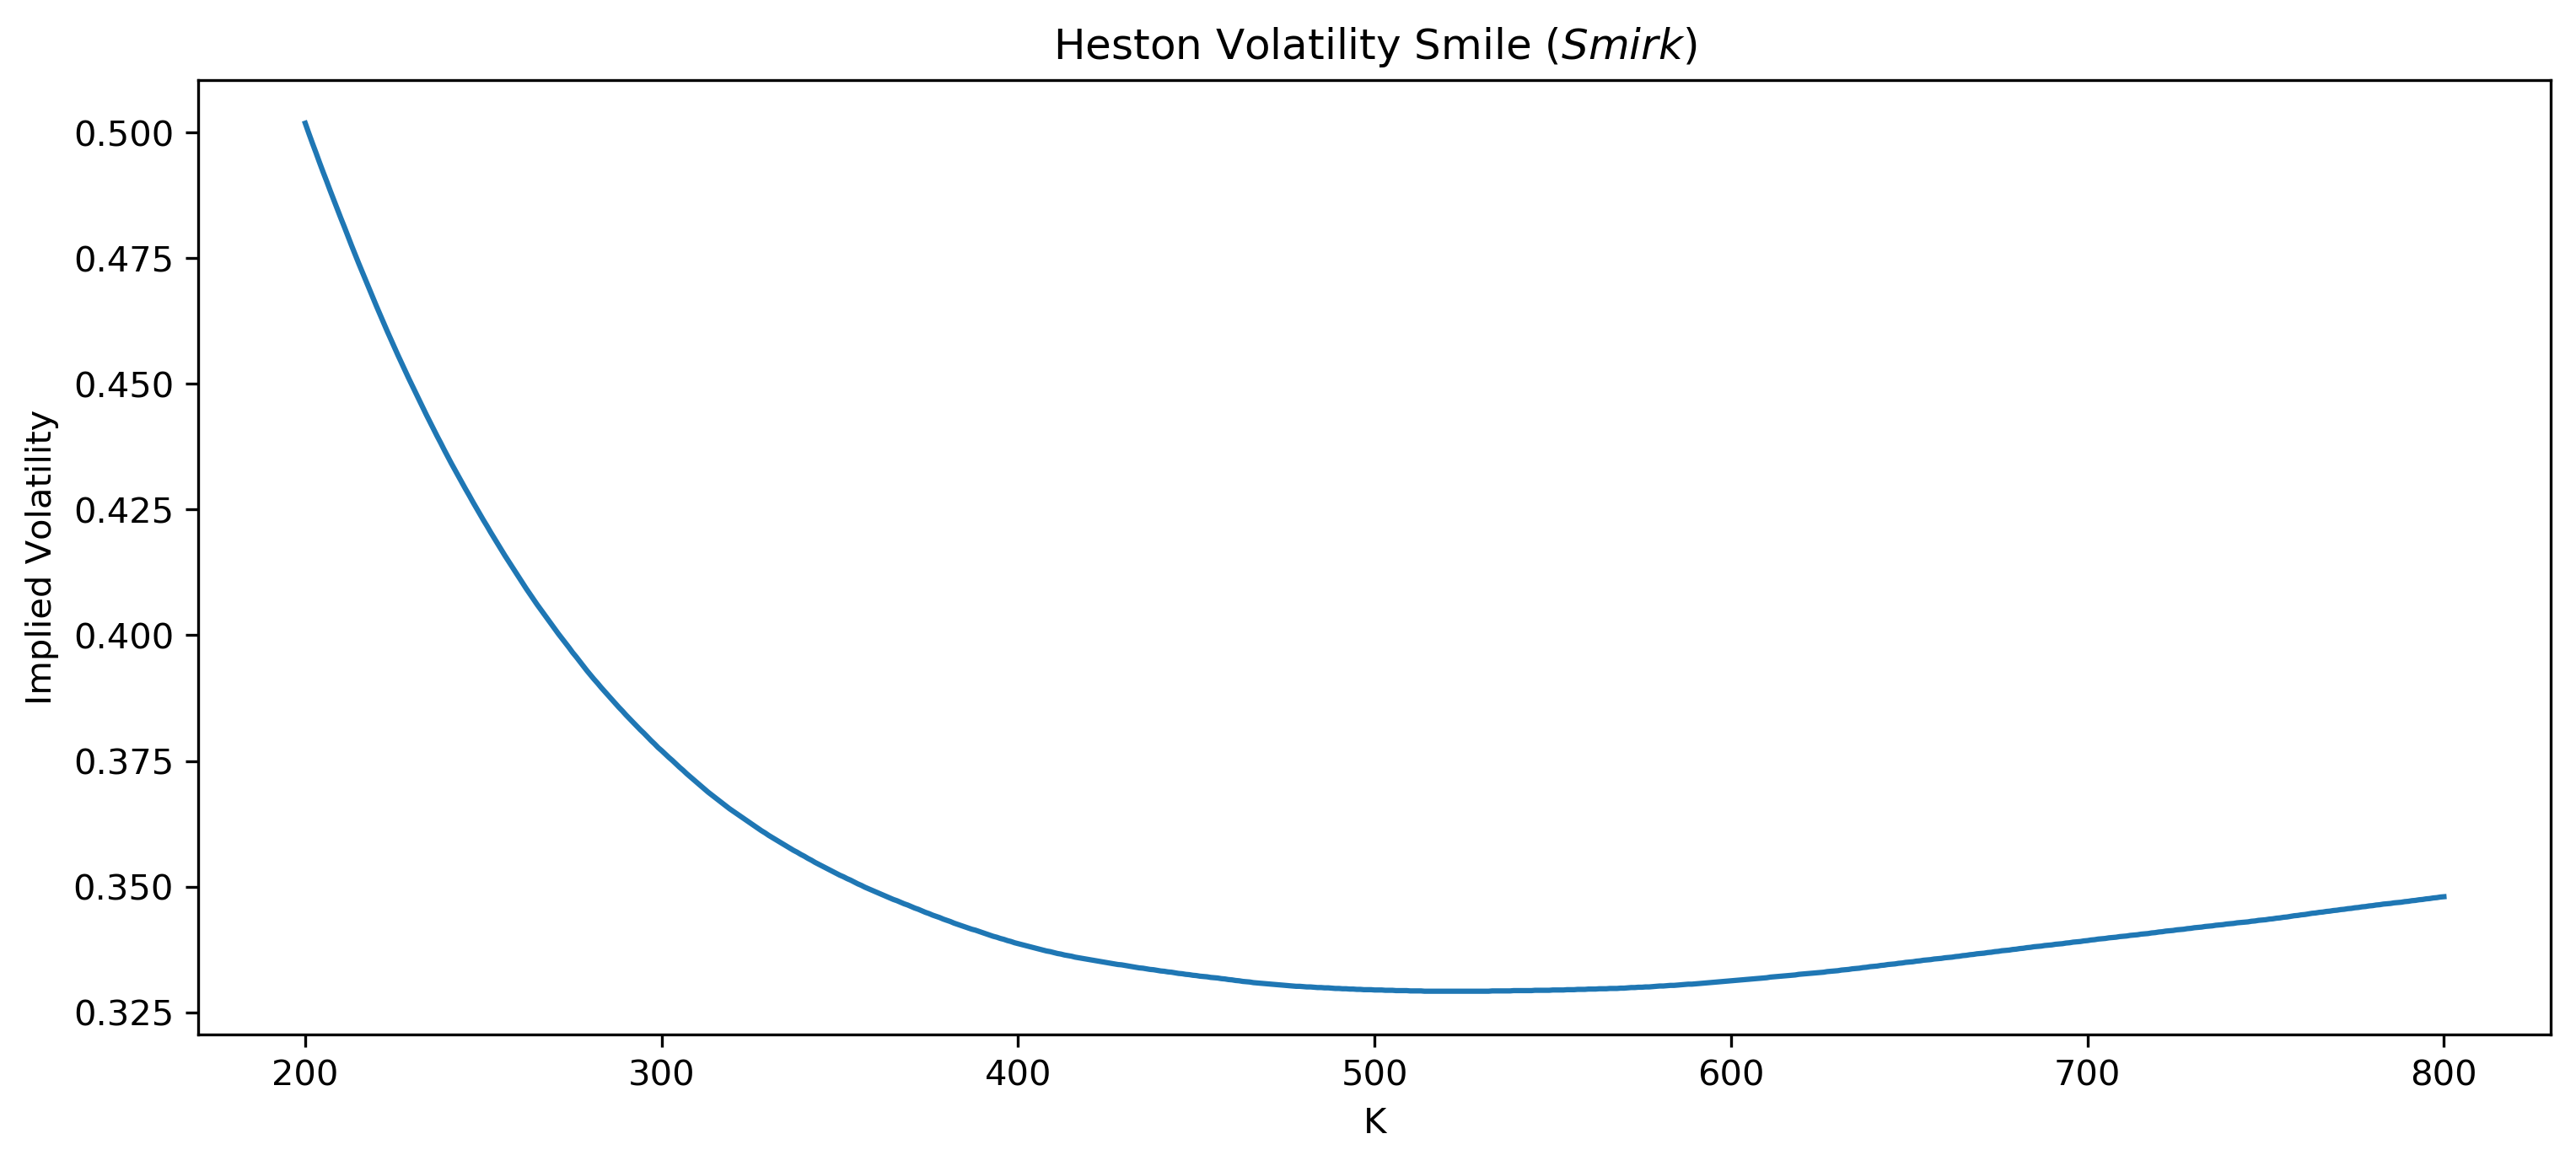

In [74]:
T = 1
r = 0.0
a = 0.1
b = 1.0
eta = 0.5
S0 = 500.0
V0 = 0.1
dt = 0.01

new_strikes = np.array([200.0 + i for i in range(601)])

hestons = []
for _ in range(10000):
    res = Heston(r, a, b, eta, S0, V0, T, dt)
    if type(res) == float:
        continue
    hestons.append(res[-1])
hestons = np.array(hestons)

ivs = [0.0 for _ in range(601)]
cs = []
for i, k in enumerate(new_strikes):
    C_market = np.mean(np.maximum(hestons - k, 0.0))*np.exp(-r*T)
    cs.append(C_market)
    ivs[i] = BS_call_implied_vol(T, k, S0, 0.0, r, C_market)

plt.figure(figsize=(12, 5), dpi=300)
plt.title("Heston Volatility Smile ($Smirk$)")
plt.plot(new_strikes, ivs)
plt.xlabel("K")
plt.ylabel("Implied Volatility")
plt.show()

The results verifies the **Implied Volatility Smirk.**

Note that due to different randomness of the Heston simulation, the shape of the smirk might vary.